# 얼굴 감정 인식

### 0. 개요
- 영상을 업로드 하면 얼굴에서 감정을 인식하여 %로 반환
- Kaggle FER2013 emotion recognition 데이터 활용

### 1. 라이브러리 불러오기

In [1]:
## 일반
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from time import sleep
import re
import os
import argparse
from collections import OrderedDict
import matplotlib.animation as animation

## 이미지 처리
from scipy.ndimage import zoom
from scipy.spatial import distance
import imutils
from scipy import ndimage
import cv2
import dlib
from __future__ import division
from imutils import face_utils

## CNN models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras import models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model

## SVM models
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

## Same trained models
import h5py
from tensorflow.keras.models import model_from_json
import pickle

### 2. 데이터 불러오기

In [2]:
path = '/content/'

In [4]:
pd.options.mode.chained_assignment = None # df를 여러 번 인덱싱 or 슬라이싱 할 때 발생하는 오류 비활성호
dataset = pd.read_csv(path + 'fer2013.csv')

train = dataset[dataset["Usage"] == "Training"]
test = dataset[dataset["Usage"] == "PublicTest"]

# 공백으로 구분된 문자열을 Numpy 배열로 변환
train['pixels'] = train['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))
test['pixels'] = test['pixels'].apply(lambda image_px : np.fromstring(image_px, sep = ' '))

- 데이터 탐색

In [5]:
dataset.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


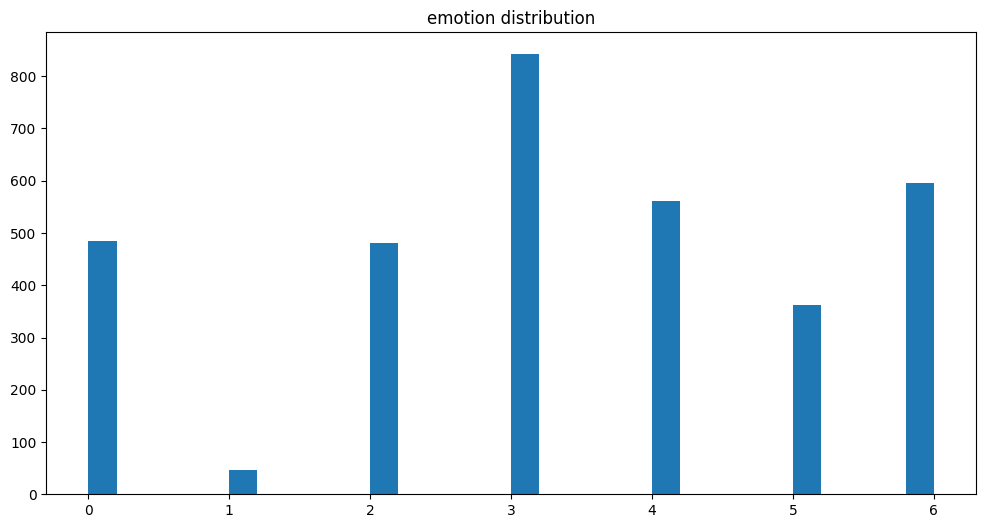

In [6]:
plt.figure(figsize=(12, 6))
plt.hist(dataset["emotion"], bins=30)
plt.title("emotion distribution")
plt.show()

In [7]:
train.shape, test.shape

((3372, 3), (0, 3))

### 3. 데이터셋 생성

In [8]:
shape_x, shape_y = 48, 48

In [9]:
X_train = train.iloc[:, 1].values
y_train = train.iloc[:, 0].values
X_test = test.iloc[:, 1].values
y_test = test.iloc[:, 0].values

# 데이터를 세로로 쌓아서 2D 배열 생성
X_train = np.vstack(X_train)
X_test = np.vstack(X_test)

# 데이터 차원 변경(X는 4D, y는 2D)
X_train = np.reshape(X_train, (X_train.shape[0],48,48,1))
y_train = np.reshape(y_train, (y_train.shape[0],1))
X_test = np.reshape(X_test, (X_test.shape[0],48,48,1))
y_test = np.reshape(y_test, (y_test.shape[0],1))

X_train.shape, y_train.shape, X_test.shape, y_test.shape

ValueError: need at least one array to concatenate

In [ ]:
# float 타입으로 변환
train_data = X_train.astype('float32')
test_data = X_test.astype('float32')

# 스케일링
train_data /= 255
test_data /= 255

# 원-핫 인코딩
train_labels_one_hot = to_categorical(y_train)
test_labels_one_hot = to_categorical(y_test)

### 4. 클래스 정의

In [10]:
classes = np.unique(y_train)
classes

array([0, 1, 2, 3, 4, 5, 6])

In [11]:
# 입력 이미지의 차원 추출
nRows,nCols,nDims = X_train.shape[1:]
input_shape = (nRows, nCols, nDims)

ValueError: not enough values to unpack (expected 3, got 1)

In [ ]:
# 라벨 정의
def get_label(argument):
    labels = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad' , 5:'Surprise', 6:'Neutral'}
    return(labels.get(argument, "Invalid emotion"))

In [ ]:
plt.figure(figsize=[10,5])

# 훈련 데이터
plt.subplot(121)
plt.imshow(np.squeeze(X_train[22,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_train[0].item()))))

# 테스트 데이터
plt.subplot(122)
plt.imshow(np.squeeze(X_test[20,:,:], axis = 2), cmap='gray')
plt.title("Ground Truth : {}".format(get_label(int(y_test[1500].item()))))

plt.show()

### 5. 얼굴 탐지